# LIGHT GBM

### Facial Emotion Recognition

Paulina Peralta, Ferran Tubert, Katherine Soto, Blanca Gallardo y Agustí Costabella

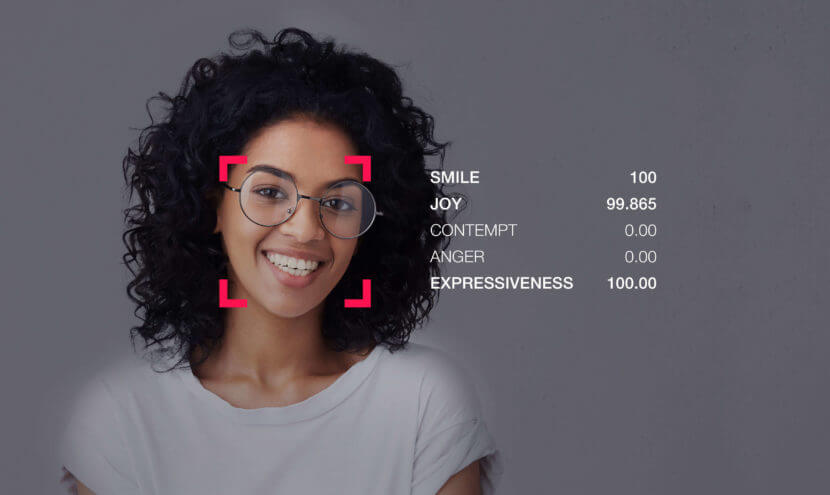

## CARGA DE LIBRERÍAS Y DATOS

In [1]:
# !pip install lightgbm
# !pip install tensorflow
# !pip install torch
# !pip install timm
# !pip install optuna
# !pip install pandas

In [2]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [3]:
df = pd.read_csv("archive/data.csv", index_col=0)
base_folder = "archive/dataset"

df.head()

path     label
0  Surprise/1bd930d6a1c717c11be33db74823f661cb53f...  Surprise
1       Surprise/cropped_emotions.100096~12fffff.png  Surprise
2  Surprise/0df0e470e33093f5b72a8197fa209d684032c...  Surprise
3       Surprise/cropped_emotions.260779~12fffff.png  Surprise
4       Surprise/cropped_emotions.263616~12fffff.png  Surprise

In [4]:
df.describe()

path    label
count                                               15453    15453
unique                                              15453        6
top     Surprise/1bd930d6a1c717c11be33db74823f661cb53f...  Neutral
freq                                                    1     4027

Tras cargar los datos, hacemos una observación inicial mediante la funcion head(). Vemos que cada fila contiene el path de la imagen y la etiqueta del sentimiento que muestra.

## EDA

In [5]:
labels = df['label'].unique()
print(labels)

['Surprise' 'Sad' 'Ahegao' 'Happy' 'Neutral' 'Angry']


In [6]:
print(df['label'].value_counts())

label
Neutral     4027
Sad         3934
Happy       3740
Angry       1313
Surprise    1234
Ahegao      1205
Name: count, dtype: int64


/tmp/ipykernel_42835/2456384004.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='viridis')


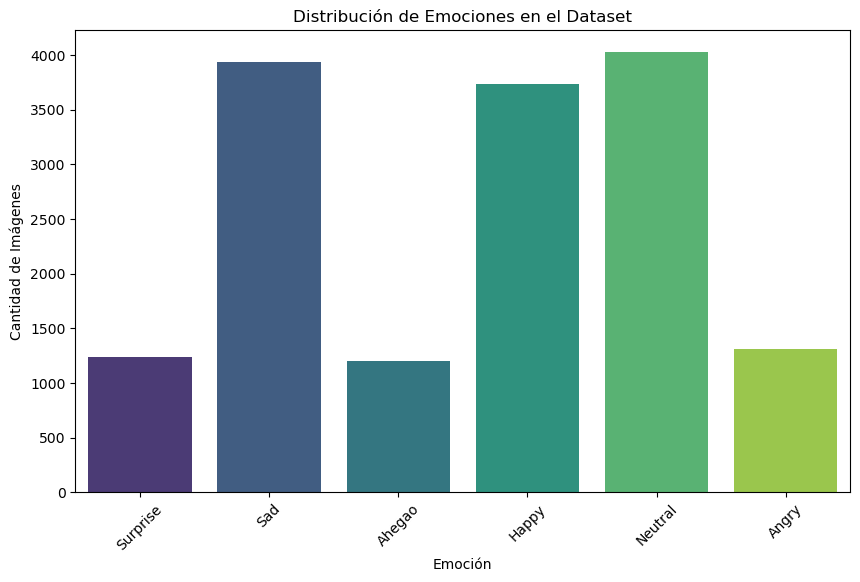

label
Neutral     26.059665
Sad         25.457840
Happy       24.202420
Angry        8.496732
Surprise     7.985504
Ahegao       7.797839
Name: proportion, dtype: float64


In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Distribución de Emociones en el Dataset')
plt.xlabel('Emoción')
plt.ylabel('Cantidad de Imágenes')
plt.xticks(rotation=45)
plt.show()

# Mostrar porcentajes
print(df['label'].value_counts(normalize=True) * 100)

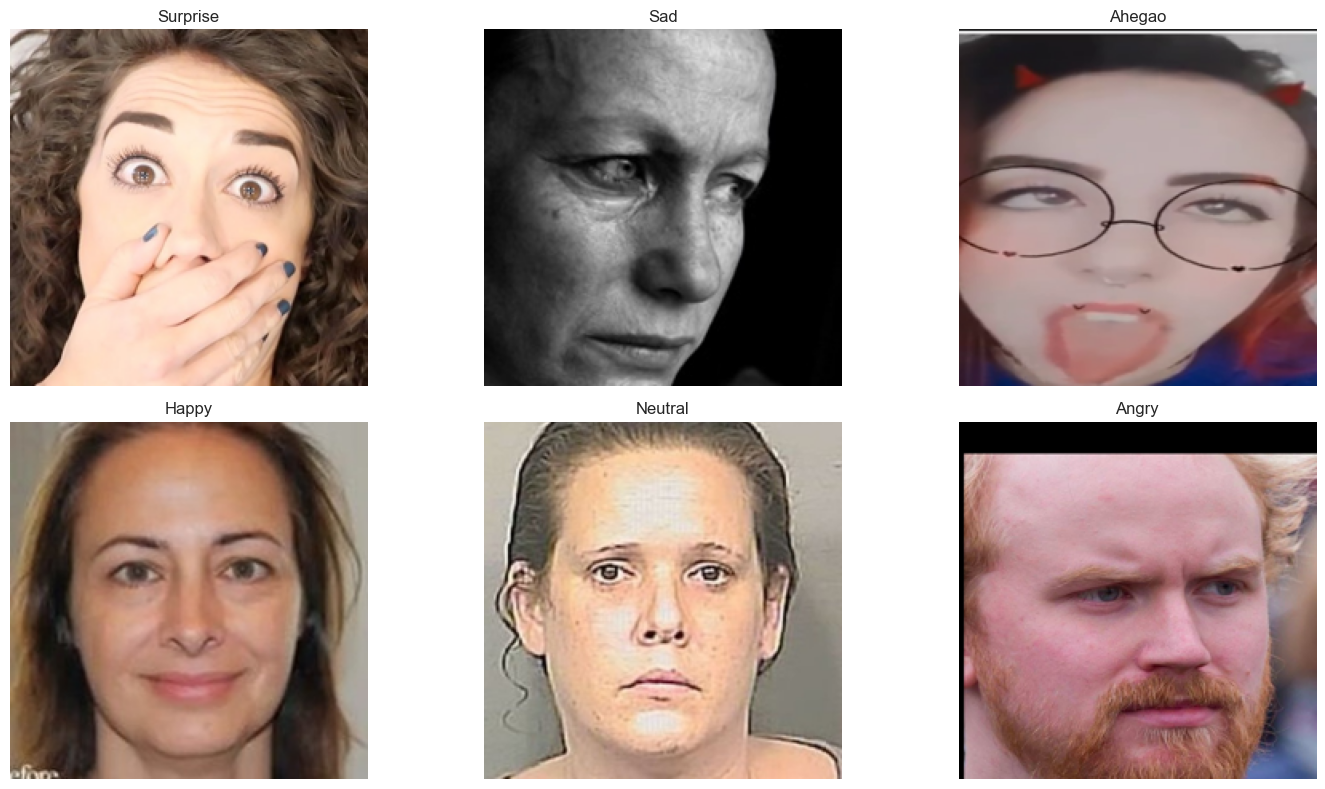

In [14]:
def display_class_grid(df, base_folder, images_per_class=1, size=(224,224)):
    """
    Muestra las imágenes representativas de cada clase en una cuadrícula.
    """
    labels = df['label'].unique()
    n_classes = len(labels)

    n_rows = 2
    n_cols = 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8))

    for i, lbl in enumerate(labels):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col]

        img_path = Path(base_folder) / df[df['label']==lbl]['path'].iloc[0]
        img = Image.open(img_path).convert("RGB")
        img = img.resize(size)

        ax.imshow(np.array(img))
        ax.set_title(lbl)
        ax.axis('off')

    for j in range(n_classes, n_rows*n_cols):
        row = j // n_cols
        col = j % n_cols
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

display_class_grid(df, base_folder="dataset")

Tras la exploración inicial, se han implementado tres modelos distintos para intentar abordar este problema de clasificación.

Finalmente se realiza un versionamiento de la data

In [8]:
data_v1 = df.copy()

## 1r MODELO: PCA + LIGHTGBM

En primer lugar, se ha realizado la preparación de los datos de imagen, incluyendo la apertura de las imágenes, conversión a formato RGB, el redimensionamiento a 48×48 píxeles y la transformación en vectores unidimensionales.

A continuación, se ha desarrollado un modelo de LightGBM, utilizando como entrada las componentes principales obtenidas tras realizar el análisis PCA a partir de estos vectores.

### PREPARACIÓN

In [16]:
def load_image(path, size=(48,48)):
    img = Image.open(path).convert("RGB")
    img = img.resize(size)
    return np.array(img).flatten()

X = np.array([load_image(os.path.join(base_folder, p)) for p in df['path']])
y = df['label'].values

print("Shape X:", X.shape)

Shape X: (15453, 6912)


### PCA

In [19]:
# Normalizamos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(random_state=42)
pca.fit(X_scaled)

PCA(random_state=42)

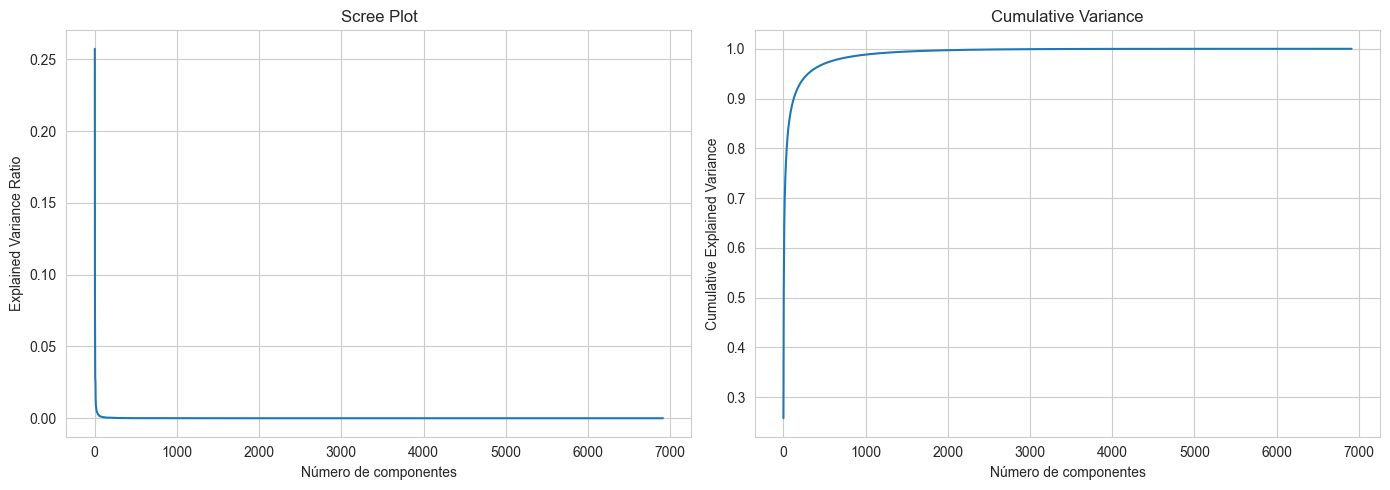

Número de componentes para alcanzar 90% de varianza: 127


In [23]:
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

n_90 = np.argmax(cumulative_var >= 0.90) + 1
var_90 = cumulative_var[n_90 - 1]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree Plot
axes[0].plot(range(1, len(explained_var)+1), explained_var)
axes[0].set_xlabel("Número de componentes")
axes[0].set_ylabel("Explained Variance Ratio")
axes[0].set_title("Scree Plot")

# Cumulative Variance Plot
axes[1].plot(range(1, len(cumulative_var)+1), cumulative_var)
axes[1].set_xlabel("Número de componentes")
axes[1].set_ylabel("Cumulative Explained Variance")
axes[1].set_title("Cumulative Variance")

plt.tight_layout()
plt.show()

print(f"Número de componentes para alcanzar 90% de varianza: {n_90}")

In [24]:
# PCA: reducimos a 127 componentes
pca = PCA(n_components=127, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Shape X after PCA:", X_pca.shape)

Shape X after PCA: (15453, 127)


### TRAINING

In [25]:
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y_enc, test_size=0.2, random_state=42)

In [26]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'objective': 'multiclass',
    'num_class': len(le.classes_)
}

model = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=500)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32385
[LightGBM] [Info] Number of data points in the train set: 12362, number of used features: 127
[LightGBM] [Info] Start training from score -2.570140
[LightGBM] [Info] Start training from score -2.451652
[LightGBM] [Info] Start training from score -1.416682
[LightGBM] [Info] Start training from score -1.339671
[LightGBM] [Info] Start training from score -1.374873
[LightGBM] [Info] Start training from score -2.525688


### EVALUATION

Accuracy: 0.533484309285021
              precision    recall  f1-score   support

      Ahegao       0.80      0.62      0.70       259
       Angry       0.50      0.21      0.29       248
       Happy       0.62      0.68      0.65       742
     Neutral       0.45      0.57      0.50       789
         Sad       0.47      0.52      0.49       808
    Surprise       0.62      0.28      0.38       245

    accuracy                           0.53      3091
   macro avg       0.58      0.48      0.50      3091
weighted avg       0.55      0.53      0.53      3091



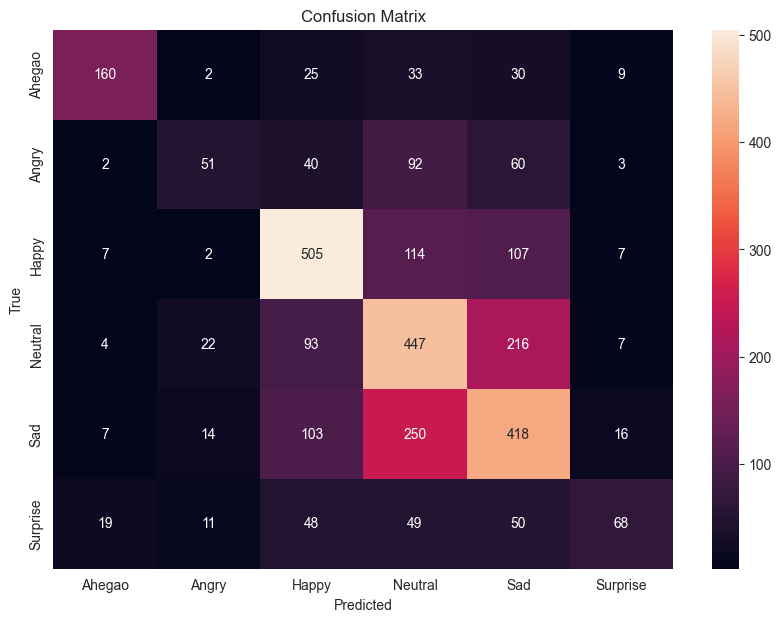

In [27]:
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Accuracy:", accuracy_score(y_test, y_pred_classes))
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

# Confusion Matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 2do MODELO: RESNET + LIGHTGBM

En este segundo modelo, se ha usado ResNet para la selección de las características.

### RESNET

In [19]:
print("Cargando ResNet50...")
model_resnet = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def extract_features(dataframe, base_path):
    features = []
    valid_idx = []

    print(f"Buscando imágenes en: {base_path}")

    for i, row in tqdm(dataframe.iterrows(), total=dataframe.shape[0]):
        img_path = os.path.join(base_path, row['path'])

        if os.path.exists(img_path):
            try:
                img = load_img(img_path, target_size=(224, 224))
                x = img_to_array(img)
                x = np.expand_dims(x, axis=0)
                x = preprocess_input(x)

                feat = model_resnet.predict(x, verbose=0)
                features.append(feat.flatten())
                valid_idx.append(i)
            except Exception as e:
                print(f"\nError procesando {img_path}: {e}")

    if not features:
        raise ValueError(f"¡Error! No se encontró ninguna imagen en {base_path}. Revisa si la carpeta se llama 'dataset' o 'Dataset'.")

    return np.array(features), valid_idx
X_final, valid_idx = extract_features(df, base_folder)
y_final = df.iloc[valid_idx]['label']

print(f"\nProceso completado: {X_final.shape[0]} imágenes convertidas en vectores.")

Cargando ResNet50...
Buscando imágenes en: dataset


100%|██████████| 15453/15453 [21:28<00:00, 11.99it/s]   



✅ Proceso completado: 15453 imágenes convertidas en vectores.


In [23]:
feat_df = pd.DataFrame(X_final)
print("Dimensiones de la matriz:", feat_df.shape)
print("\nPrimeras filas y columnas de los vectores de características:")
print(feat_df.head())

Dimensiones de la matriz: (15453, 2048)

Primeras filas y columnas de los vectores de características:
       0         1         2         3         4         5         6     \
0  0.496617  0.139131  0.155245  2.799950  1.447236  0.564393  0.012060   
1  0.230145  0.000000  0.000000  4.751883  1.579607  0.000000  0.395160   
2  0.329837  0.611843  0.385615  4.605169  0.338918  0.552332  0.215344   
3  0.008249  0.054291  0.000000  1.172217  1.715303  0.029490  0.263881   
4  0.997469  0.000000  0.000000  2.586093  1.458544  0.018728  0.460487   

       7         8         9     ...      2038      2039      2040      2041  \
0  0.521521  0.000000  0.036671  ...  1.018966  0.620308  0.197637  0.652460   
1  0.453113  0.010505  0.461284  ...  0.000000  0.384692  0.912363  2.281070   
2  0.197784  0.017143  0.339351  ...  1.712160  0.189448  0.129805  0.766713   
3  0.175682  0.000000  0.410643  ...  0.023789  0.154742  0.155502  2.756782   
4  0.321675  0.022507  0.577700  ...  0.120519

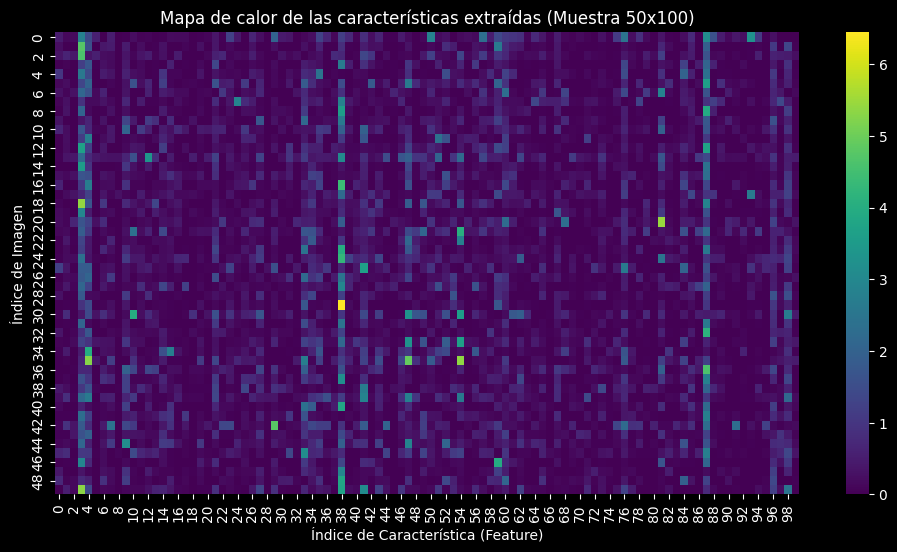

In [24]:
plt.figure(figsize=(12, 6))
sns.heatmap(X_final[:50, :100], cmap='viridis')
plt.title("Mapa de calor de las características extraídas (Muestra 50x100)")
plt.xlabel("Índice de Característica (Feature)")
plt.ylabel("Índice de Imagen")
plt.show()

In [29]:
le = LabelEncoder()
y_numeric = le.fit_transform(y_final)
for i, nombre_emocion in enumerate(le.classes_):
    print(f"Número {i}: {nombre_emocion}")

Número 0: Ahegao
Número 1: Angry
Número 2: Happy
Número 3: Neutral
Número 4: Sad
Número 5: Surprise


### TRAINING

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X_final,
    y_numeric,
    test_size=0.2,
    random_state=42,
    stratify=y_numeric
)

print(f"Datos para entrenamiento: {X_train.shape}")
print(f"Datos para test: {X_test.shape}")

Datos para entrenamiento: (12362, 2048)
Datos para test: (3091, 2048)


In [37]:
clf = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(le.classes_),
    metric='multi_logloss',
    class_weight='balanced',
    learning_rate=0.05,
    n_estimators=1000,
    num_leaves=31,
    n_jobs=-1,
    random_state=42
)

print("Iniciando entrenamiento de LightGBM...")
clf.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='multi_logloss',
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=50)
    ]
)

Iniciando entrenamiento de LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 522240
[LightGBM] [Info] Number of data points in the train set: 12362, number of used features: 2048
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 1.02988
[100]	valid_0's multi_logloss: 0.915009
[150]	valid_0's multi_logloss: 0.875317
[200]	valid_0's multi_logloss: 0.863301
[250]	valid_0's multi_logloss: 0.864186
Early stopping, best iteration is:
[233]	valid_0's multi_logloss: 0.861888


LGBMClassifier(class_weight='balanced', learning_rate=0.05,
               metric='multi_logloss', n_estimators=1000, n_jobs=-1,
               num_class=6, objective='multiclass', random_state=42)

### EVALUATION


   INFORME DE RENDIMIENTO
              precision    recall  f1-score   support

      Ahegao       0.92      0.90      0.91       241
       Angry       0.51      0.48      0.50       263
       Happy       0.77      0.78      0.78       748
     Neutral       0.60      0.65      0.62       805
         Sad       0.60      0.58      0.59       787
    Surprise       0.66      0.57      0.61       247

    accuracy                           0.66      3091
   macro avg       0.68      0.66      0.67      3091
weighted avg       0.66      0.66      0.66      3091



/Users/blancagallardo/PyCharmMiscProject/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


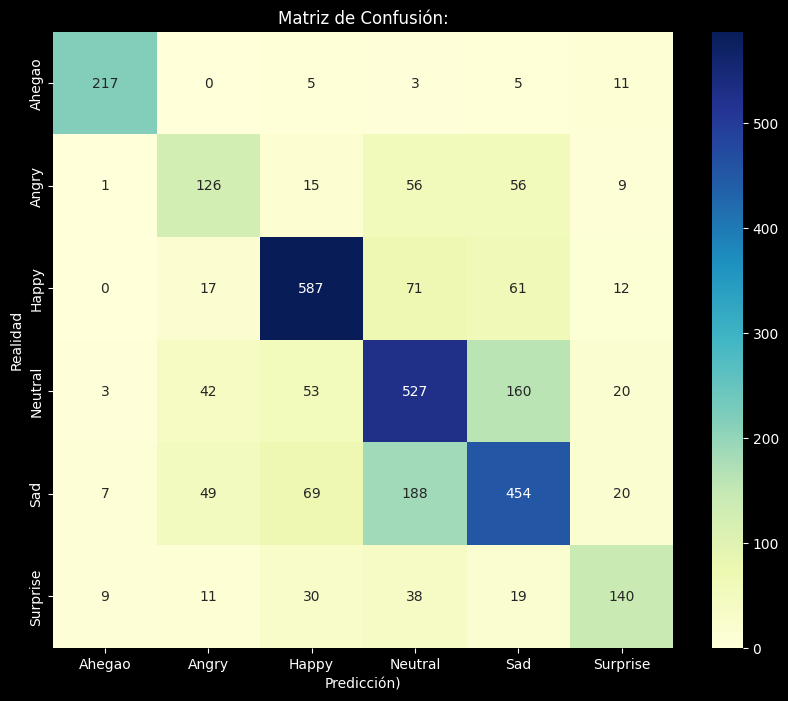

In [38]:
y_pred = clf.predict(X_test)

print("\n" + "="*30)
print("   INFORME DE RENDIMIENTO")
print("="*30)

print(classification_report(y_test, y_pred, target_names=le.classes_))

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de Confusión:')
plt.xlabel('Predicción)')
plt.ylabel('Realidad')
plt.show()

## 3r MODELO: Vit + LIGHTGBM y Optuna
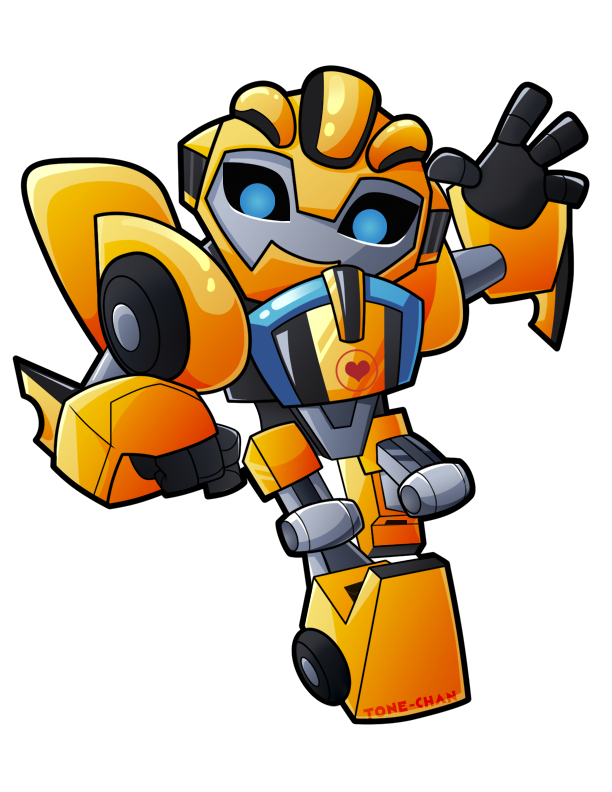

<div class="alert alert-info">
    <h3 style="margin-top:0;">Vit</h3>
</div>

In [9]:
import os
import pandas as pd
import numpy as np
import torch
import timm
import optuna
import lightgbm as lgb
from PIL import Image
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
# df_sample = data_v1.sample(n=1000, random_state=42).reset_index(drop=True)
BASE_PATH = 'archive'  
DATASET_DIR = os.path.join(BASE_PATH, 'dataset')

df_sample = data_v1.copy()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

Usando dispositivo: cpu


### 1. Configuración del modelo ViT (Vision Transformer)

Carga el modelo Vision Transformer Base preentrenado desde la librería timm:
* ViT-Base tiene 12 capas
* ViT-Large tiene 24 bloques
* ViT-Huge tiene 32 bloques

Parametros:
* num_classes=0 → indica que se extrae embeddings, no clasificar
* model.to(device) → lo mueve a GPU (si está disponible) o CPU
* model.eval() → pone el modelo en modo evaluación (desactiva dropout, etc.)

```
VisionTransformer:
├── patch_embed (convierte imagen en patches)
├── blocks (0-11) → 12 bloques Transformer
├── norm (normalización final)
└── head (clasificador - Identity porque num_classes=0)
```

In [30]:
model_name = 'vit_base_patch16_224'
model = timm.create_model(model_name, pretrained=True, num_classes=0)
model.to(device)
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

**Explicacion del Resultado**

**1. Generación de Patches, embedding lineal y codificación posicional**
```
(patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
)
```
14x14 = 196 patches de 768 pixeles/patch

<!-- <img src="attachment: 238c943b-fa25-4ca1-84bb-a4c6fc48fedf.png" width="350"> -->
Ejm: Patch original
[R11, G11, B11, R12, G12, B12, ..., R16,16, G16,16, B16,16]

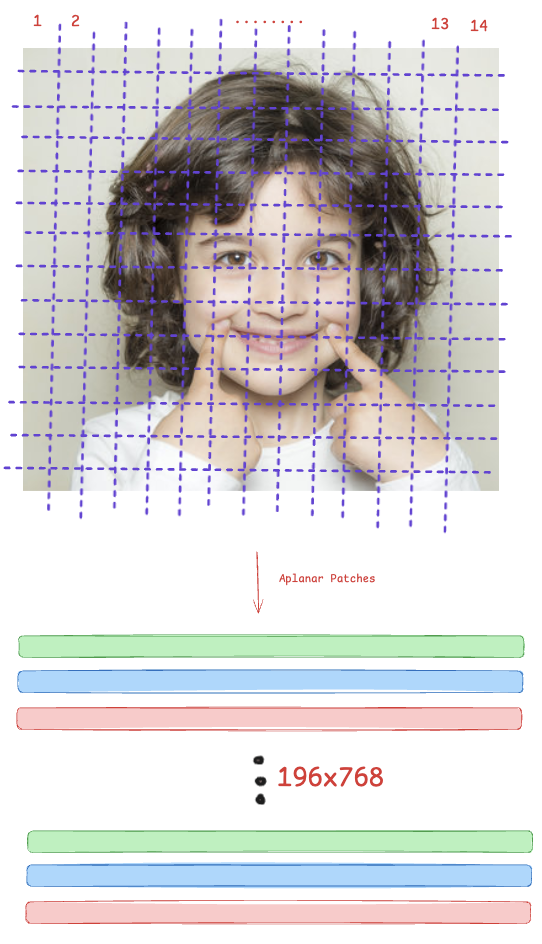

***2. Embedding lineal -> 196 patches de 768 dimensiones***
por ejm: [d1, d2, d3, d4, d5, ..., d768]

Divide la imagen 224×224 en patches de 16×16 píxeles
Resultado: (224÷16) × (224÷16) = 14×14 = 196 patches
Cada patch se proyecta a un vector de 768 dimensiones

***3. Codificacion posicional (suma)***
Patch #0 [768] + Pos #0 [768] = Patch #0 con pos [768]

**4. Codificador transformer: 12 bloques de transformers**
Cada bloque tiene la misma estructura y procesa los 196 patches
```
Block(
  (norm1): LayerNorm((768,), ...)
  (attn): Attention(...)          # ← Mecanismo de atención
  (norm2): LayerNorm((768,), ...)
  (mlp): Mlp(...)                 # ← Red neuronal feedforward
)
```

* Attention: 
```
(attn): Attention(
    (qkv): Linear(768 → 2304)  # Genera Q, K, V (768×3 = 2304)
    (proj): Linear(768 → 768)   # Proyección de salida
)
```

* MLP (Multi-Layer Perceptron) - Red Feedforward
* Expande a 3072 dimensiones, aplica no-linealidad (GELU), y vuelve a 768

```
(mlp): Mlp(
    (fc1): Linear(768 → 3072)   # Expande 4x
    (act): GELU()                # Activación
    (fc2): Linear(3072 → 768)   # Vuelve a 768
)
```
Pooling implicito dentro de timm

***Cabecera de salida***
(head): Identity()

**Resumen: Visualización del Proceso**
```
┌─────────────────────────────────┐
│  Imagen: Cara con emoción       │
│        224×224×3                │
└─────────────┬───────────────────┘
              │
              ↓ PatchEmbed
┌─────────────────────────────────┐
│  196 patches de 16×16 píxeles   │
│  Cada uno → vector 768D         │
└─────────────┬───────────────────┘
              │
              ↓ Block 0
┌─────────────────────────────────┐
│ Atención: ¿Ojos + boca = triste?│
│ MLP: Procesa características    │
└─────────────┬───────────────────┘
              │
              ↓ Blocks 1-11 (más capas)
              │
              ↓ LayerNorm final
┌─────────────────────────────────┐
│  Vector embedding: [768 números]│
│  Representa toda la imagen      │
└─────────────────────────────────┘
```
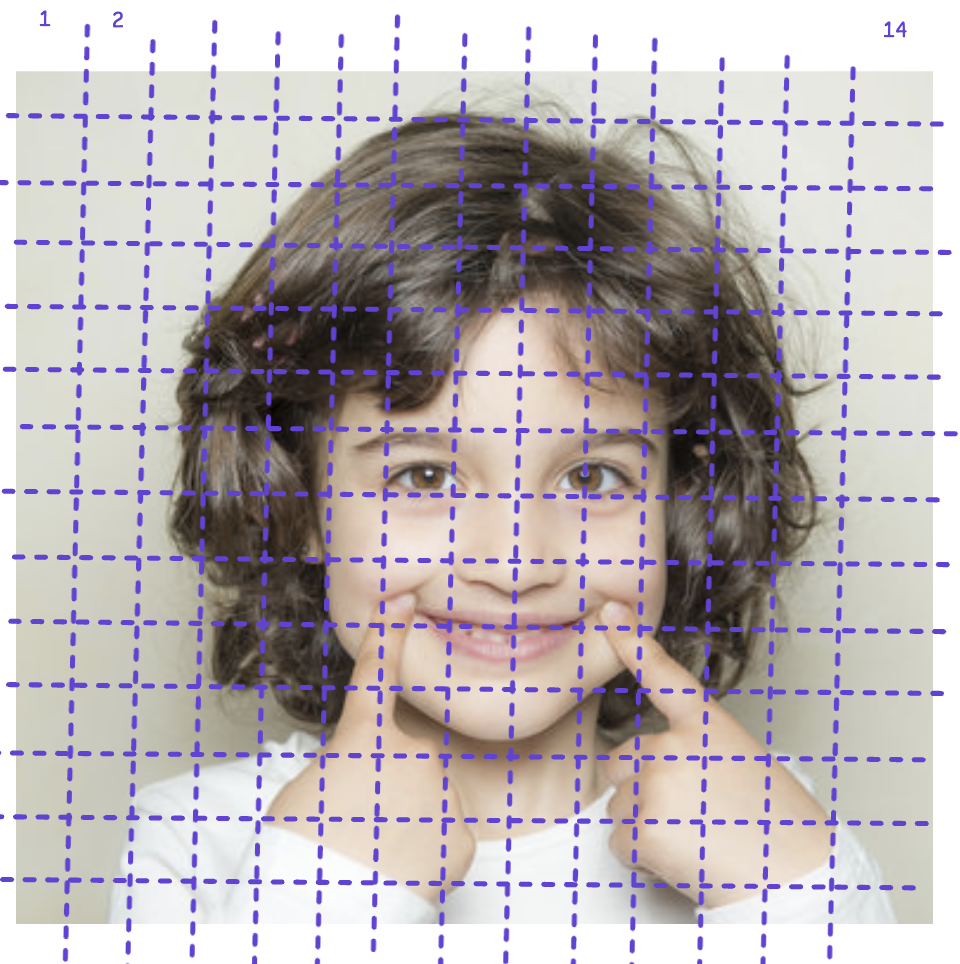

### Transformaciones de preprocesamiento

* Resize: ajusta todas las imágenes a 224×224 píxeles (tamaño esperado por ViT)
* ToTensor: convierte la imagen PIL a tensor PyTorch
* Normalize: normaliza con la media y desviación estándar de ImageNet (dataset con el que se preentrenó el modelo)

In [31]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

### 3. Extracción de características (embeddings) por cada imagen

Recorre cada fila de lDataFrame df_sample
torch.no_grad() → no calcula gradientes (solo inferencia, no entrenamiento)

**Procesamiento de cada imagen**
Construye la ruta completa de la imagen
La abre y convierte a RGB
Aplica las transformaciones
unsqueeze(0) → añade dimensión de batch: [3, 224, 224] → [1, 3, 224, 224]

**Extraccion de embeddings**
Pasa la imagen por el modelo → obtiene un vector de características (embedding) de 768 dimensiones
.cpu() → mueve el resultado a CPU
.numpy() → convierte a NumPy array
.flatten() → asegura que sea un vector 1D



In [33]:
features = []

with torch.no_grad():

    for idx, row in tqdm(df_sample.iterrows(), total=len(df_sample)):
        #Procesamiento de cada imagen
        img_path = os.path.join(DATASET_DIR, row['path'])
        try:
            img = Image.open(img_path).convert('RGB')
            img_tensor = transform(img).unsqueeze(0).to(device)
            
            #Extrae embedding
            output = model(img_tensor)
            features.append(output.cpu().numpy().flatten())
            
        except Exception as e:
            print(f"Error en {img_path}: {e}")
            features.append(np.zeros(768))

100%|██████████| 15453/15453 [50:10<00:00,  5.13it/s]  


**Guardado de resultados**

Convierte la lista de embeddings a matriz NumPy
Extrae las etiquetas
Guarda ambos en archivos .npy para uso posterior

Resultado final: Una matriz X_sample de forma (n_imágenes, 768) donde cada fila es la representación vectorial de una imagen, lista para entrenar un clasificador o hacer análisis de similitud.

In [34]:
X_sample = np.array(features)
y_sample = df_sample['label'].values # O tu label_encoded


np.save('X_sample.npy', X_sample)
np.save('y_sample.npy', y_sample)

print(f"\nForma de la matriz X: {X_sample.shape}")


Forma de la matriz X: (15453, 768)


<div class="alert alert-info">
    <h3 style="margin-top:0;">LIGHTGBM + Optuna</h3>
</div>

***Carga de las muestras***

In [11]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

X = np.load('X_sample.npy')
y_raw = np.load('y_sample.npy', allow_pickle=True)
# Convierte a DataFrame con nombres de columnas genéricos
X = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])

**Codificación de etiquetas y division de muestras**

* Convierte etiquetas de texto a números: "happy"→0, "sad"→1, etc.
* Guarda class_names para interpretar resultados después

train/test

* Divide datos en 80% entrenamiento y 20% validación
* stratify=y → mantiene la proporción de clases en ambos conjuntos

In [12]:
le = LabelEncoder()
y = le.fit_transform(y_raw)
class_names = le.classes_


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**Optuna** Optimización

Parámetros que se optimizan:

* lambda_l1 y lambda_l2: regularización L1 y L2 (evitan overfitting)
* num_leaves: complejidad del árbol (2-256 hojas)
* feature_fraction: % de características a usar por árbol (0.4-1.0)
* bagging_fraction: % de datos para entrenar cada árbol (0.4-1.0)
* bagging_freq: cada cuántas iteraciones hacer bagging (1-7)
* min_child_samples: mínimo de muestras por hoja (5-100)
* learning_rate: tasa de aprendizaje (0.01-0.1)

Retorna accuracy (lo que Optuna intentará maximizar)

In [13]:
def objective(trial):
    param = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        "num_class": len(class_names),
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
    }

    gbm = lgb.LGBMClassifier(**param)
    gbm.fit(X_train, y_train)
    
    preds = gbm.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print(f"Mejor Accuracy en Optuna: {study.best_value:.4f}")
print(f"Mejores parámetros: {study.best_params}")

[I 2026-02-12 14:49:15,686] A new study created in memory with name: no-name-3f1272a1-69fd-41c8-b7af-2684ddce991d
[I 2026-02-12 14:49:32,702] Trial 0 finished with value: 0.6599805888062116 and parameters: {'lambda_l1': 3.458499703718743e-05, 'lambda_l2': 0.020196989745616758, 'num_leaves': 143, 'feature_fraction': 0.5311355498250832, 'bagging_fraction': 0.5185776197903592, 'bagging_freq': 6, 'min_child_samples': 58, 'learning_rate': 0.02134183422714878}. Best is trial 0 with value: 0.6599805888062116.
[I 2026-02-12 14:50:46,323] Trial 1 finished with value: 0.6625687479780007 and parameters: {'lambda_l1': 1.1662691662184364e-08, 'lambda_l2': 3.875615427436218e-07, 'num_leaves': 242, 'feature_fraction': 0.5600195570089154, 'bagging_fraction': 0.5112202061415168, 'bagging_freq': 4, 'min_child_samples': 14, 'learning_rate': 0.04135638055601447}. Best is trial 1 with value: 0.6625687479780007.
[I 2026-02-12 14:51:22,894] Trial 2 finished with value: 0.6806858621805241 and parameters: {'la

Mejor Accuracy en Optuna: 0.6846
Mejores parámetros: {'lambda_l1': 0.0009687829284612747, 'lambda_l2': 5.685321829281087e-06, 'num_leaves': 110, 'feature_fraction': 0.9206132057997164, 'bagging_fraction': 0.626541034358678, 'bagging_freq': 3, 'min_child_samples': 72, 'learning_rate': 0.056585802682695856}


**Entrenamiento final con los mejores parametros**

In [14]:
best_params = study.best_params
best_params["objective"] = "multiclass"
best_params["num_class"] = len(class_names)

final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(X_train, y_train)

LGBMClassifier(bagging_fraction=0.626541034358678, bagging_freq=3,
               feature_fraction=0.9206132057997164,
               lambda_l1=0.0009687829284612747, lambda_l2=5.685321829281087e-06,
               learning_rate=0.056585802682695856, min_child_samples=72,
               num_class=6, num_leaves=110, objective='multiclass')

**Evaluación del modelo**

======REPORTE DE CLASIFICACIÓN======

              precision    recall  f1-score   support

      Ahegao       0.93      0.90      0.91       241
       Angry       0.56      0.30      0.39       263
       Happy       0.83      0.87      0.85       748
     Neutral       0.61      0.71      0.66       805
         Sad       0.59      0.65      0.62       787
    Surprise       0.76      0.32      0.45       247

    accuracy                           0.68      3091
   macro avg       0.71      0.63      0.65      3091
weighted avg       0.69      0.68      0.67      3091



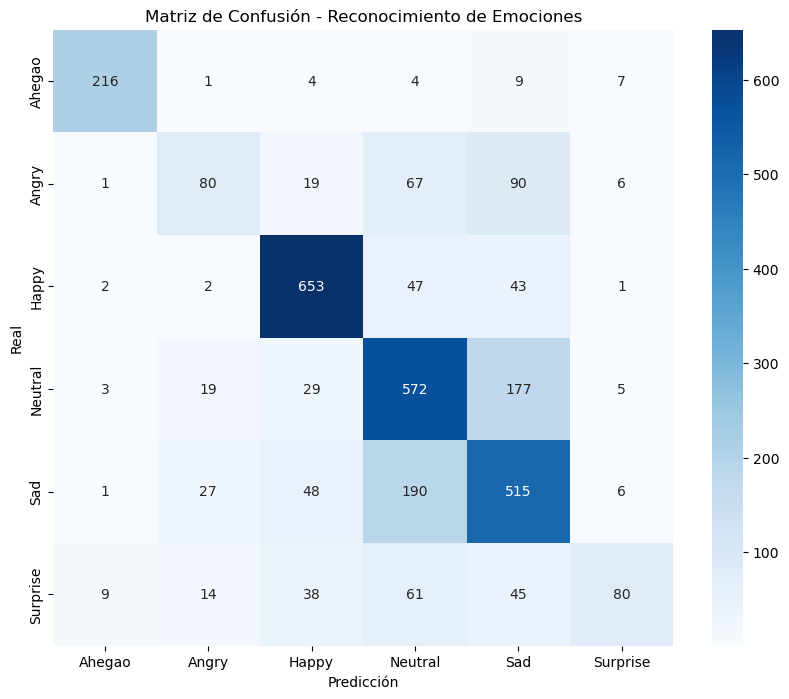

In [15]:
y_pred = final_model.predict(X_val)

print("======REPORTE DE CLASIFICACIÓN======\n")

print(classification_report(y_val, y_pred, target_names=class_names))

# Matriz de Confusión
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Reconocimiento de Emociones')
plt.show()

<div class="alert alert-info">
    <h3 style="margin-top:0;">Analisis del impacto del Vit sobre el modelo LightGBM y los resultados</h3>
</div>

En esta seccion analizaré cuáles de las 768 dimensiones del embedding generado por el ViT fueron las más determinantes para las decisiones del modelo LightGBM


ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS

====Top 20 Dimensiones más importantes del embedding ViT:======
     Feature  Importance
209  Dim_209         312
560  Dim_560         225
607  Dim_607         215
244  Dim_244         213
120  Dim_120         185
158  Dim_158         176
748  Dim_748         173
6      Dim_6         173
55    Dim_55         169
309  Dim_309         165
182  Dim_182         162
345  Dim_345         155
31    Dim_31         152
67    Dim_67         149
145  Dim_145         146
420  Dim_420         142
387  Dim_387         140
2      Dim_2         131
129  Dim_129         123
673  Dim_673         123


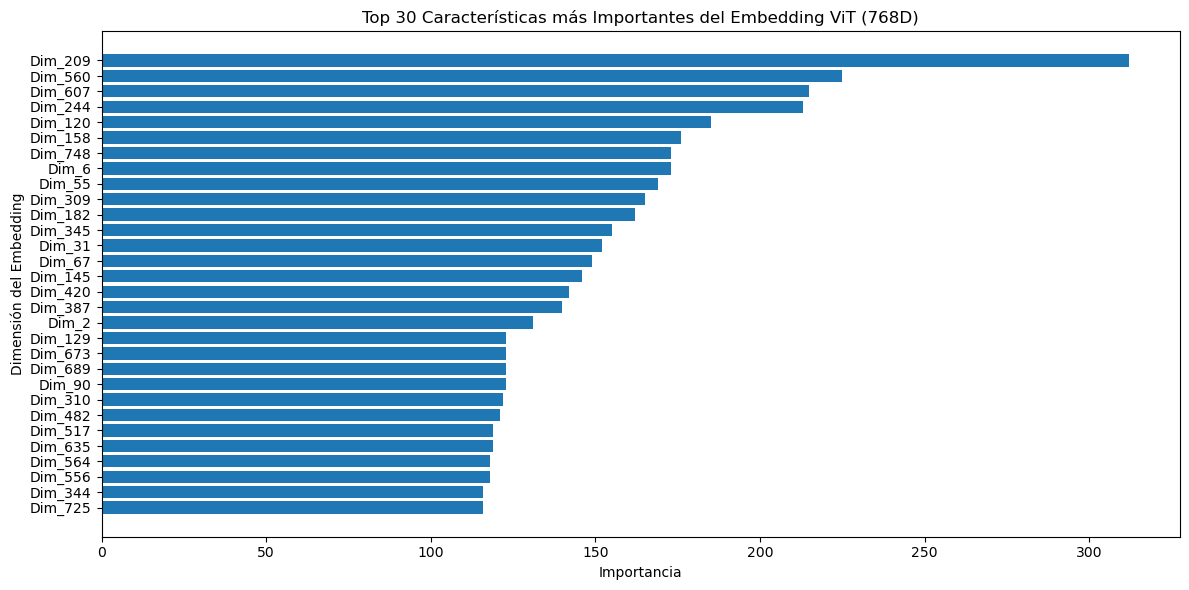

In [20]:
print("\n" + "="*40)
print("ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS")
print("="*40)

feature_importance = final_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': [f'Dim_{i}' for i in range(len(feature_importance))],
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("\n====Top 20 Dimensiones más importantes del embedding ViT:======")
print(importance_df.head(20))

#visualizacion
plt.figure(figsize=(12, 6))
top_n = 30
plt.barh(range(top_n), importance_df['Importance'].head(top_n)[::-1])
plt.yticks(range(top_n), importance_df['Feature'].head(top_n)[::-1])
plt.xlabel('Importancia')
plt.ylabel('Dimensión del Embedding')
plt.title(f'Top {top_n} Características más Importantes del Embedding ViT (768D)')
plt.tight_layout()
plt.show()

Se observa que Dim_209 tiene importancia ~320 
   • Las siguientes 5-6 dimensiones tienen ~200-240
   • El resto tiene <200 y cae rápidamente

Esto sugiere que dicha dimensión captura un patrón visual clave (como una curvatura específica de la boca o los ojos) que discrimina fuertemente entre emociones.

**DISTRIBUCIÓN DE IMPORTANCIA**

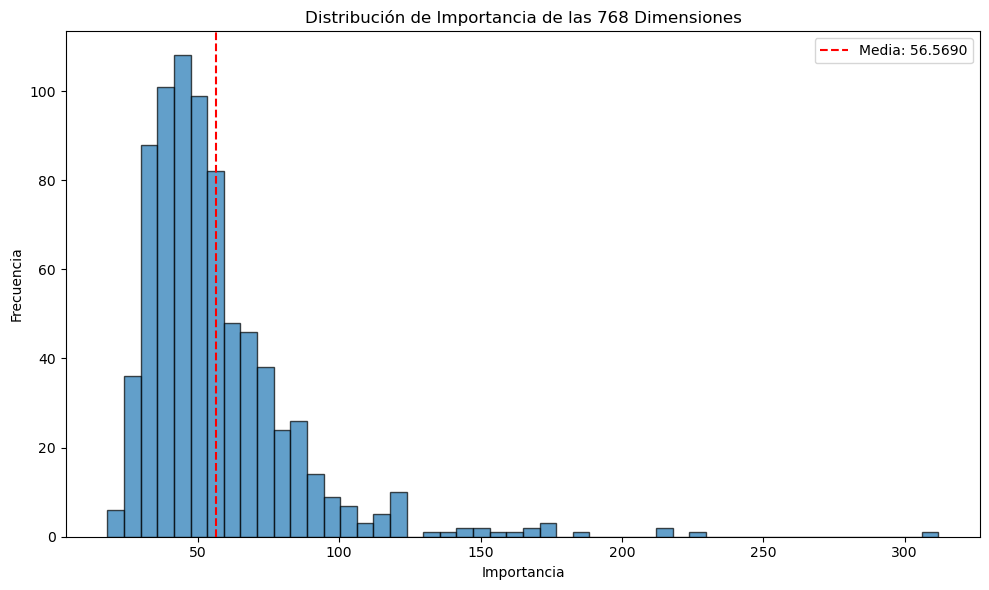

In [22]:
plt.figure(figsize=(10, 6))
plt.hist(feature_importance, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Importancia')
plt.ylabel('Frecuencia')
plt.title('Distribución de Importancia de las 768 Dimensiones')
plt.axvline(feature_importance.mean(), color='red', linestyle='--', label=f'Media: {feature_importance.mean():.4f}')
plt.legend()
plt.tight_layout()
plt.show()


* La mayoría de las dimensiones tienen una importancia baja (concentradas a la izquierda de la media de 56.57). Esto es comun en problemas con vision
* Se observa una "cola larga" hacia la derecha. Esas dimensiones que se alejan hacia el valor 300 son mis "características estrella"

**HEATMAP DE IMPORTANCIA (Visualización 2D)**

768 dimensiones organizadas en grid aproximado

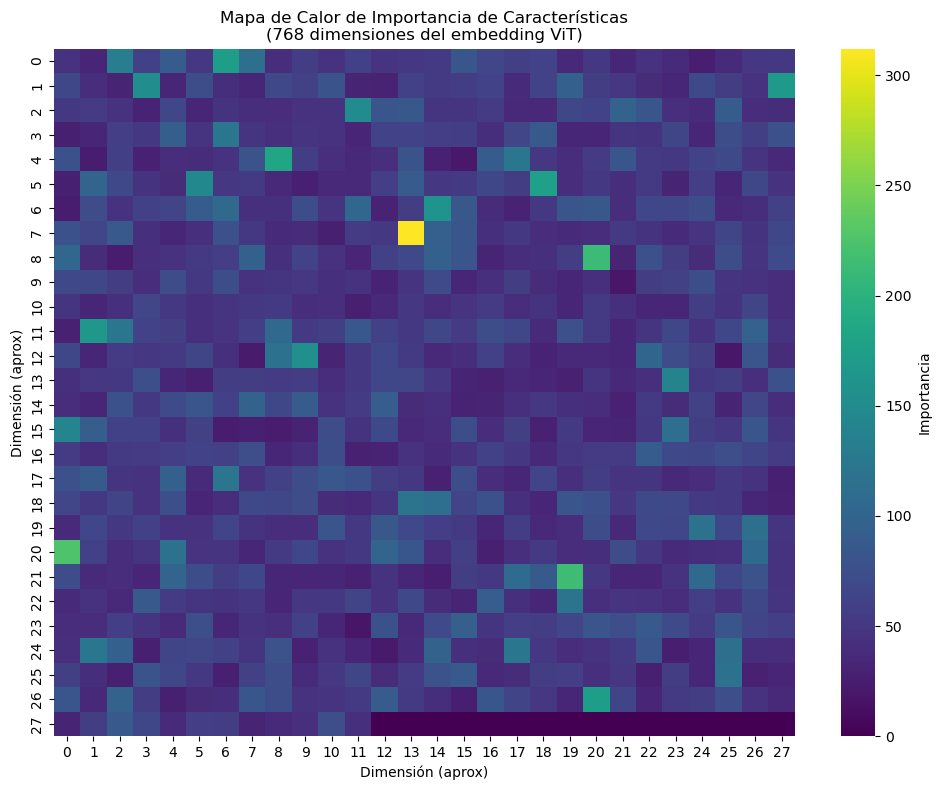

In [24]:
import math
side = int(math.sqrt(768))  # ~27.7, usamos 28x28 = 784, recortamos a 768

# Rellenar con ceros hasta 784 para hacer cuadrado
importance_padded = np.pad(feature_importance, (0, 784 - 768), mode='constant')
importance_grid = importance_padded.reshape(28, 28)

plt.figure(figsize=(10, 8))
sns.heatmap(importance_grid, cmap='viridis', cbar_kws={'label': 'Importancia'})
plt.title('Mapa de Calor de Importancia de Características\n(768 dimensiones del embedding ViT)')
plt.xlabel('Dimensión (aprox)')
plt.ylabel('Dimensión (aprox)')
plt.tight_layout()
plt.show()

Se transformado el vector de importancia de 768 dimensiones en una matriz de $28 \times 28$ (aproximadamente) para visualizar espacialmente cómo se distribuye la relevancia:
* El mapa es predominantemente oscuro (baja importancia), salpicado por "puntos calientes" amarillos y verdes
* El punto más brillante corresponde a esa Dimensión 209

**Estadísticas Descriptivas de Importancia**
Este resumen estadístico me permite cuantificar la dispersión de la relevancia de mis datos

In [25]:
print("ESTADÍSTICAS DE IMPORTANCIA\n")

print(f"Total de características: {len(feature_importance)}")
print(f"Importancia media: {feature_importance.mean():.6f}")
print(f"Importancia mediana: {np.median(feature_importance):.6f}")
print(f"Importancia máxima: {feature_importance.max():.6f}")
print(f"Importancia mínima: {feature_importance.min():.6f}")
print(f"Desviación estándar: {feature_importance.std():.6f}")

# Porcentaje de importancia acumulada
cumsum = np.cumsum(np.sort(feature_importance)[::-1])
total_importance = cumsum[-1]

for threshold in [0.5, 0.8, 0.9, 0.95]:
    n_features = np.argmax(cumsum >= threshold * total_importance) + 1
    print(f"\n{threshold*100:.0f}% de importancia acumulada con: {n_features} características ({n_features/768*100:.1f}% del total)")

ESTADÍSTICAS DE IMPORTANCIA

Total de características: 768
Importancia media: 56.569010
Importancia mediana: 50.000000
Importancia máxima: 312.000000
Importancia mínima: 18.000000
Desviación estándar: 27.979818

50% de importancia acumulada con: 257 características (33.5% del total)

80% de importancia acumulada con: 519 características (67.6% del total)

90% de importancia acumulada con: 629 características (81.9% del total)

95% de importancia acumulada con: 692 características (90.1% del total)


* Se observa que el 50% de la importancia acumulada proviene de solo 257 características (33.5%).
* 95% de la capacidad predictiva, solo necesito el 90% de las dimensiones. Esto confirma que hay cierta redundancia en el embedding del ViT para este problema de emociones, y que mi optimización con Optuna ha sabido priorizar los componentes más informativos

## Análisis de Errores por Clase

In [26]:
print("ANÁLISIS DE ERRORES POR CLASE\n")

# Análisis de confusiones
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

for i, class_name in enumerate(class_names):
    # Diagonal = aciertos
    accuracy_class = cm_normalized[i, i]
    
    # Errores más comunes (confusiones)
    errors = [(class_names[j], cm[i, j], cm_normalized[i, j]) 
              for j in range(len(class_names)) if i != j and cm[i, j] > 0]
    errors.sort(key=lambda x: x[1], reverse=True)
    
    print(f"\n{class_name.upper()}:")
    print(f"  Accuracy: {accuracy_class:.2%}")
    print(f"  Total muestras: {cm[i].sum()}")
    print(f"  Correctas: {cm[i, i]}")
    if errors:
        print(f"  Confusiones más comunes:")
        for conf_class, count, pct in errors[:3]:  # Top 3 confusiones
            print(f"    • Confundida con {conf_class}: {count} veces ({pct:.1%})")


#Guardar importancia de características
importance_df.to_csv('feature_importance_vit.csv', index=False)
print("\nImportancia de características guardada en: feature_importance_vit.csv")

#Guardar métricas por clase
report_dict = classification_report(y_val, y_pred, target_names=class_names, output_dict=True)
metrics_df = pd.DataFrame(report_dict).transpose()
metrics_df.to_csv('classification_metrics.csv')
print("Métricas de clasificación guardadas en: classification_metrics.csv")

ANÁLISIS DE ERRORES POR CLASE


AHEGAO:
  Accuracy: 89.63%
  Total muestras: 241
  Correctas: 216
  Confusiones más comunes:
    • Confundida con Sad: 9 veces (3.7%)
    • Confundida con Surprise: 7 veces (2.9%)
    • Confundida con Happy: 4 veces (1.7%)

ANGRY:
  Accuracy: 30.42%
  Total muestras: 263
  Correctas: 80
  Confusiones más comunes:
    • Confundida con Sad: 90 veces (34.2%)
    • Confundida con Neutral: 67 veces (25.5%)
    • Confundida con Happy: 19 veces (7.2%)

HAPPY:
  Accuracy: 87.30%
  Total muestras: 748
  Correctas: 653
  Confusiones más comunes:
    • Confundida con Neutral: 47 veces (6.3%)
    • Confundida con Sad: 43 veces (5.7%)
    • Confundida con Ahegao: 2 veces (0.3%)

NEUTRAL:
  Accuracy: 71.06%
  Total muestras: 805
  Correctas: 572
  Confusiones más comunes:
    • Confundida con Sad: 177 veces (22.0%)
    • Confundida con Happy: 29 veces (3.6%)
    • Confundida con Angry: 19 veces (2.4%)

SAD:
  Accuracy: 65.44%
  Total muestras: 787
  Correctas: 515
  C

Finalmente se concluye que :
* Las clases Ahegao (89.63%) y Happy (87.30%) son las que mejores hemos logrado clasificar. Esto tiene sentido, ya que suelen tener rasgos faciales muy distintivos y exagerados que el ViT captura con facilidad.
* Las expresiones mas dificiles de clasificar son Angry y Surprise: El modelo sufre significativamente con Angry (30.42%) y Surprise (32.39%):
    * Angry se confunde masivamente con Sad (34%) y Neutral (25%)
    * Surprise también se diluye hacia Neutral y Sad.
* Se observa que el modelo tiende a predecir Sad o Neutral cuando tiene dudas. Esto suele suceder por un desbalance en los datos o porque esas clases actúan como un "punto medio" visual en el espacio de características.

<div class="alert alert-info">
    <h3 style="margin-top:0;">Conclusiones</h3>
</div>

1. Se logró implementar un buen modelo usando el Vision Transformer (ViT) para la extracción de características con la eficiencia de clasificacion de lightgbm y optuna. Sobretodo detectando las siguientes emociones:
    * Ahegao (89.6%)
    * Happy (87.3%)

2. El 50% de la capacidad predictiva se concentra en solo 257 dimensiones (33.5% del total)
    * Esto es una oportunidad ya que en el futuro se podria reducir la dimensionalidad, lo que permitiría obtener un modelo mas ligero y rápido sin necesitar tanto rendimiento y seria muy bueno para llevar a producción

3. Este proyecto demuestra que la combinación de Transformers y Gradient Boosting es una alternativa competitiva a las redes neuronales densas tradicionales

***En comparación con los otros modelos:***

4. El ViT captura mejor las relaciones del rostro porque, a diferencia de las convoluciones locales, utiliza Positional Encodings para inyectar información sobre la ubicación espacial de cada parche. Esto, ayuda a captar mejor las expresiones

5. ViT > ResNet porque:
   Captura relaciones globales cara completa → embedding
   más discriminativo para emociones, aunque concentrado.

6. Con respecto a la eficiencia del espacio de features: Vit es mas eficiente, necesita menos dimensiones para capturar las emociones. Esto también se presencia en el HeatMap
    * Resnet - Dimens del Embed: 2048D -> los utiles ~200 (10%)
    * ViT-Base - 768D -> ~50-100 (7-13%)
  
7. ResNet: procesa LOCAL (3×3 convoluciones)
           No puede ver "ojos + boca" juntos en una
           sola operación

   ViT:    procesa GLOBAL (atención entre 196 patches)
           Dim_209 probablemente captura la relación
           COMPLETA del rostro en un solo vector


**Mejoras en el modelo**

8. Por lo tanto las mejoras que se podria hacer para lograr un mejor accuracy serian: reducir la dimensionalidad y balancear la muestra en la fase de entrenamiento

```
   ViT (768D)
    ↓
PCA (→ 100D, mantiene >90% varianza)
    ↓
Balanceo (SMOTE para Angry + Surprise)
    ↓
LightGBM + Optuna (200 trials)
    ↓
75-80% accuracy esperado
```

9. Otra mejora es cambiar el modelo Vit base por otro que tiene patches mas pequeños asi tendria la captura de micro expresiones. Por ejm: 'vit_base_patch8_224'
   * Patches más pequeños → más detalle
   * 8×8 = 784 patches (vs 196 actuales)

Con estas mejoras se pretende llegar a un Accuracy de ˜80%

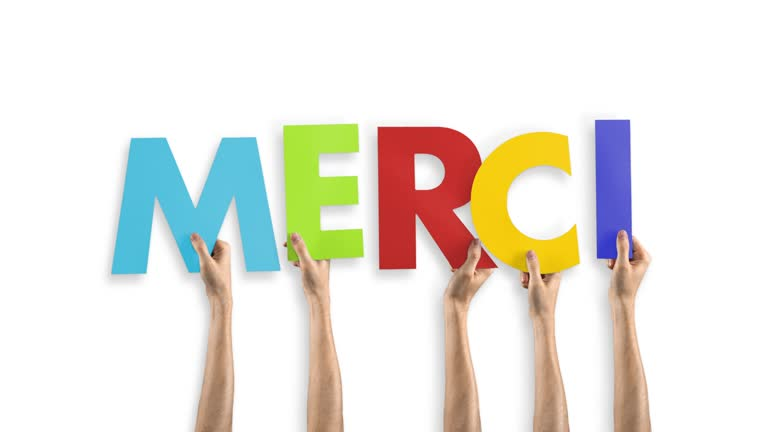